# Introduction to Pytorch


## `autodiff`

### Autodiff for simple gradient descent

Load needed libraries

$$
\newcommand\p[1]{{\left(#1\right)}}
\newcommand\code[1]{\texttt{#1}}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

Here is a simple example of how to find the minimum of the function
$x\mapsto\p{x-3}^2$ using the autodiff functionality of Pytorch.

First initialize a tensor `x` and indicate that we want to store a
gradient on it.

In [2]:
x = torch.tensor([1.0], requires_grad=True)

Create an optimizer on parameters. Here we want to optimize w.r.t.
variable `x`:

In [3]:
optimizer = optim.SGD([x], lr=0.01)

Create a computational graph using parameters (here only `x`) and
potentially other tensors.

Here we only want to compute $\p{x-3}^2$ so we define:

In [4]:
y = (x - 3) ** 2

Back-propagating gradients for `y` down to `x`. Don’t forget to reset
gradients before.

In [5]:
optimizer.zero_grad()
y.backward()

Use gradient on `x` to apply a one-step gradient descent.

In [6]:
optimizer.step()
x.grad
x

tensor([1.0400], requires_grad=True)

And last we iterate the whole process

In [7]:
it = 0
while it < 1000:
    loss = (x - 3) ** 2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if it % 20 == 0:
        print("Iteration: %d, x: %f, loss: %f" % (it, x.item(), loss.item()))
    it += 1

Iteration: 0, x: 1.079200, loss: 3.841600
Iteration: 20, x: 1.717659, loss: 1.712203
Iteration: 40, x: 2.143898, loss: 0.763130
Iteration: 60, x: 2.428460, loss: 0.340127
Iteration: 80, x: 2.618435, loss: 0.151595
Iteration: 100, x: 2.745265, loss: 0.067566
Iteration: 120, x: 2.829937, loss: 0.030114
Iteration: 140, x: 2.886464, loss: 0.013422
Iteration: 160, x: 2.924203, loss: 0.005982
Iteration: 180, x: 2.949397, loss: 0.002666
Iteration: 200, x: 2.966216, loss: 0.001188
Iteration: 220, x: 2.977446, loss: 0.000530
Iteration: 240, x: 2.984942, loss: 0.000236
Iteration: 260, x: 2.989947, loss: 0.000105
Iteration: 280, x: 2.993288, loss: 0.000047
Iteration: 300, x: 2.995519, loss: 0.000021
Iteration: 320, x: 2.997009, loss: 0.000009
Iteration: 340, x: 2.998003, loss: 0.000004
Iteration: 360, x: 2.998666, loss: 0.000002
Iteration: 380, x: 2.999109, loss: 0.000001
Iteration: 400, x: 2.999405, loss: 0.000000
Iteration: 420, x: 2.999603, loss: 0.000000
Iteration: 440, x: 2.999735, loss: 0.0

### Differentiate the exponential

The exponential function can be approximated using its Taylor expansion:
$$
\exp\p{z}\approx\sum_{k=0}^{N}\frac{z^k}{k!}
$$

First define `x`, the “parameter” and build a computational graph from
it to compute the exponential.

In [31]:
x = torch.tensor([1.0], requires_grad=True)

Compute the gradient and verify that it is correct

In [32]:
def exponential(x, n):
    fact = torch.tensor(1.0)
    exp = torch.tensor(0.0)
    for k in range(n):
        exp = exp + (x ** k)/ fact
        fact = fact * (k+1)
    return exp

exp = exponential(x, 10)
exp.backward()
print(x.grad.item())


2.7182788848876953


### Solving equations with Pytorch

Suppose we want to solve the following system of two equations

$$
e^{-e^{-(x_1 + x_2)}}=x_2 (1 + x_1^2)
$$ $$
x_1 \cos(x_2) + x_2 \sin(x_1)= 1/2
$$

Find a loss whose optimization leads to a solution of the system of
equations above.

In [64]:
def f1(x1, x2):
    return torch.exp(-torch.exp(-(x1 + x2))) - x2 * (1 + x1 **2)

def f2(x1,  x2):
    return x1 * torch.cos(x2) + x2 * torch.sin(x1) - 1/2

Use Pytorch autodiff to solve the system of equations

In [80]:
x1 = torch.tensor([0.0], requires_grad=True)
x2 = torch.tensor([0.0], requires_grad=True)

optimizer = optim.SGD([x1,x2], lr=0.1) #descente de gradient
it=0
while it<1000:
    optimizer.zero_grad() # remise a zero des gradients pour ne pas avoir d'erreur et cumuler les gradients
    loss = f1(x1,x2)**2 + f2(x1,x2)**2 # fonction a minimiser // au carré pour prendre la distance euclidienne aka dire que si 2 fonctions sont nulles alors on a une solution
    loss.backward() # calcul des gradients
    optimizer.step() # mise a jour des parametres
    it+=1
print(x1.item(), x2.item())
f1(x1,x2).item(), f2(x1,x2).item()

0.35324668884277344 0.606081485748291


(1.7881393432617188e-07, 5.960464477539063e-08)

## Linear least squares in Pytorch

### Synthetic data

We use the following linear model:

$$
y = \langle\beta,x\rangle+\varepsilon
$$

where $x\in\mathbb R^p$ and $\varepsilon\sim\mathcal N(0, \sigma^2)$.

In [86]:
import math

p = 512
N = 50000
X = torch.randn(N, p)
beta = torch.randn(p, 1) / math.sqrt(p)
y = torch.mm(X, beta) + 0.5 * torch.randn(N, 1)

### Model implementation

Every model in Pytorch is implemented as a class that derives from
`nn.Module`. The two main methods to implement are:

-   `__init__`: Declare needed building blocks to implement forward pass
-   `forward`: Implement the forward pass from the input given as
    argument

In [87]:
import torch.nn as nn


class LinearLeastSquare(nn.Module):
    def __init__(self, input_size):
        super(LinearLeastSquare, self).__init__()

        # Declaring neural networks building blocks. Here we only need
        # a linear transform.
        self.linear = nn.Linear(input_size, 1) # on veut 1 scalaire en sortie

    def forward(self, input):
        # Implementing forward pass. Return corresponding output for
        # this neural network.
        return self.linear(input) #décrit ce que fait le modèle quand on lui donne des données => applique la transformation linéaire

### Preparing dataset

In [88]:
from torch.utils.data import TensorDataset

# Gather data coming from Pytorch tensors using `TensorDataset`
dataset = TensorDataset(X, y)

In [89]:
from torch.utils.data import DataLoader
# Define `train_loader` that is an iterable on mini-batches using
# `DataLoader`
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [90]:
# Loss function to use
from torch.nn import MSELoss
loss_fn = MSELoss()

In [91]:
# Optimization algorithm
from torch.optim import SGD

# Instantiate model with `LinearLeastSquare` with the correct input
# size.
model = LinearLeastSquare(input_size=p)

In [92]:
# Use the stochastic gradient descent algorithm with a learning rate of
# 0.01 and a momentum of 0.9.
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

### Learning loop

In [93]:
epochs = 10
losses = []
for i in range(epochs):
    for src, tgt in train_loader:
        # Forward pass
        prd = model(src)

        # Backpropagation on loss
        loss = loss_fn(prd, tgt)
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        losses.append(loss.item())

    print(f"Epoch {i}/{epochs}: Last loss: {loss}")

Epoch 0/10: Last loss: 0.38182124495506287
Epoch 1/10: Last loss: 0.4604100286960602
Epoch 2/10: Last loss: 0.4457291066646576
Epoch 3/10: Last loss: 0.4719622731208801
Epoch 4/10: Last loss: 0.5545752048492432
Epoch 5/10: Last loss: 0.40543484687805176
Epoch 6/10: Last loss: 0.36689820885658264
Epoch 7/10: Last loss: 0.5340927839279175
Epoch 8/10: Last loss: 0.35446393489837646
Epoch 9/10: Last loss: 0.38933664560317993


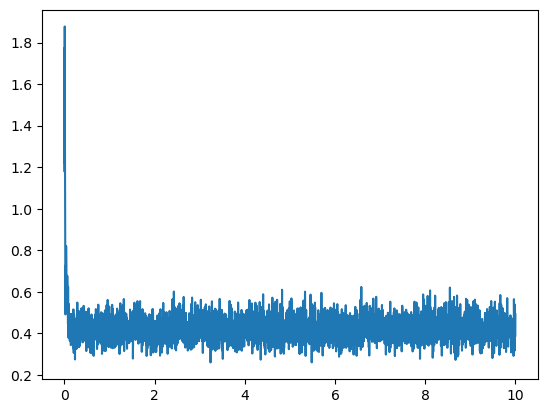

In [94]:
x = np.arange(len(losses)) / len(losses) * epochs
plt.plot(x, losses)

From the model what should be the minimum MSE?

…

### Learning loop with scheduler

From convex optimization theory the learning rate should be decreasing
toward 0. To have something approaching we use a scheduler that is
updating the learning rate every epoch.

In [ ]:
from torch.optim.lr_scheduler import MultiStepLR

# Define a scheduler
model = LinearLeastSquare(p)
optimizer = ...
scheduler = ...

In [ ]:
# Implement the learning loop with a scheduler
...

## Multi-layer perceptron

Implement a multi-layer perceptron described by the following function:
$$
f\p{x,\beta}=W_3\sigma\p{W_2\sigma\p{W_1 x}}
$$ where $\sigma\p{x}=\max\p{x, 0}$.

In [ ]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Define hyperparameters of neural network and building blocks
        ...

    def forward(self, x):
        # Implement forward pass
        ...

### Synthetic 2-dimensional spiral dataset

In [ ]:
n_classes = 3
n_loops = 2
n_samples = 1500

def spirals(n_classes=3, n_samples=1500, n_loops=2):
    klass = np.random.choice(n_classes, n_samples)
    radius = np.random.rand(n_samples)
    theta = klass * 2 * math.pi / n_classes + radius * 2 * math.pi * n_loops
    radius = radius + 0.05 * np.random.randn(n_samples)
    return np.column_stack((radius * np.cos(theta), radius * np.sin(theta))).astype("float32"), klass

X_, y_ = spirals(n_samples=n_samples, n_classes=n_classes, n_loops=n_loops)
plt.scatter(X_[:, 0], X_[:, 1], c=y_)

### Preparing dataset

In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X = torch.from_numpy(X_)
y = torch.from_numpy(y_)
dataset = TensorDataset(X, y)
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
X_, y_ = spirals(n_samples=1000, n_classes=n_classes, n_loops=n_loops)
X = torch.from_numpy(X_)
y = torch.from_numpy(y_)
test_set = TensorDataset(X, y)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

### The learning loop

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss

loss_fn = CrossEntropyLoss()
model = MultiLayerPerceptron(2, 20, 20, n_classes)
optimizer = SGD(model.parameters(), lr=0.05)
optimizer = Adam(model.parameters())

In [ ]:
import copy

epochs = 1000
losses = []
models = []
for i in range(epochs):
    for src, tgt in train_loader:
        ...

    # Accuracy on the test set
    acc = 0.
    for src, tgt in test_loader:
        prd = model(src).detach().argmax(dim=1)
        acc += sum(prd == tgt).item()

    acc /= len(test_set)
    if i % 20 == 0:
        print(f"Epoch {i}/{epochs}: Test accuracy: {acc}")

    models.append(copy.deepcopy(model))

In [ ]:
def get_image_data(model, colors, xs, ys):
    """Return color image of size H*W*4."""

    # Generate points in grid
    xx, yy = np.meshgrid(xs, ys)
    points = np.column_stack((xx.ravel(), yy.ravel())).astype("float32")
    points = torch.from_numpy(points)

    # Predict class probability on points
    prd = model(points).detach()
    prd = torch.nn.functional.softmax(prd, dim=1)

    # Build a color image from colors
    colors = torch.from_numpy(colors)
    img = torch.mm(prd, colors).numpy()
    img = img.reshape((ynum, xnum, 4))
    img = np.minimum(img, 1)

    return img

fig, ax = plt.subplots()

# Get n_classes colors in RGBa form
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
import matplotlib as mpl
colors = mpl.colors.to_rgba_array(colors)[:n_classes, :4].astype("float32")

# Draw scatter plot of test set using colors
ax.scatter(X[:, 0], X[:, 1], c=colors[y])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
xnum, ynum = (int(i) for i in fig.dpi * fig.get_size_inches())

# Create discretization
xs = np.linspace(xmin, xmax, xnum)
ys = np.linspace(ymin, ymax, ynum)
img = get_image_data(model, colors, xs, ys)

ax.imshow(img, extent=[xmin, xmax, ymin, ymax], origin="lower", alpha=.7)